## Blobs in 2D Datasets Notebook

Testing my algorithms on 2D generated datasets with centers approaching together.

In [1]:
from sklearn.datasets.samples_generator import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy.spatial import distance

from bc_utils import TestDf

Creating datasets and saving them to pandas dataframes.

In [2]:
noise_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
dataset_dfs = []
for noise in noise_vals:
    X, y = make_moons(n_samples=250, noise=0.2)
    new_dataframe = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    new_dataframe = new_dataframe
    dataset_dfs.append(new_dataframe)
    

Showing plots of the datasets.

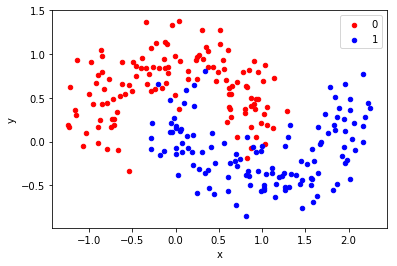

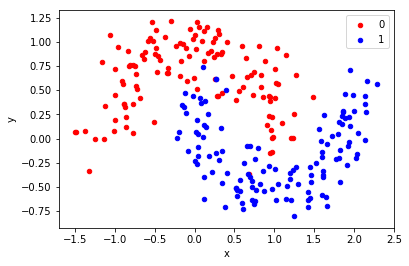

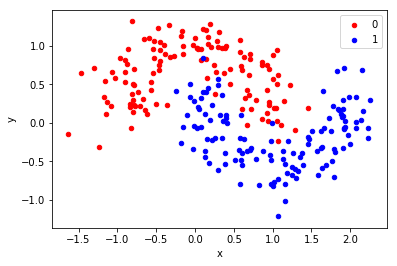

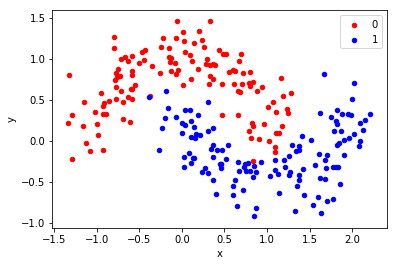

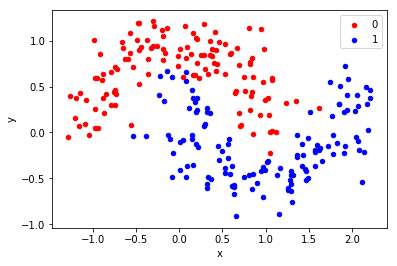

In [3]:
colors = {0:'red', 1:'blue'}
for df in dataset_dfs:
    fix, ax = pyplot.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y',
                   label=key, color=colors[key])
    pyplot.show()

Separating datasets to learn and test parts. Using own class TestDataset from utils.py

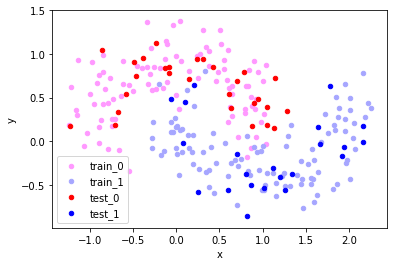

In [4]:
dataset = dataset_dfs[0]      

#creating dataset for testing algorithms
learning_dataset = TestDf(dataset)

learning_dataset.show_plot()

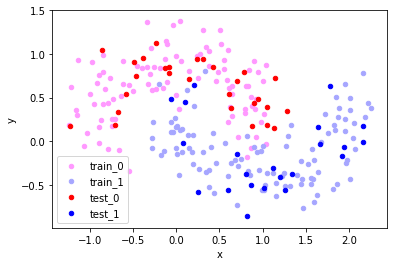

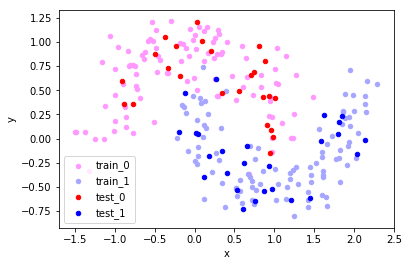

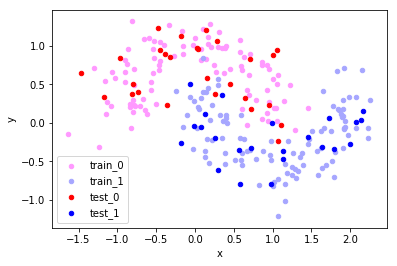

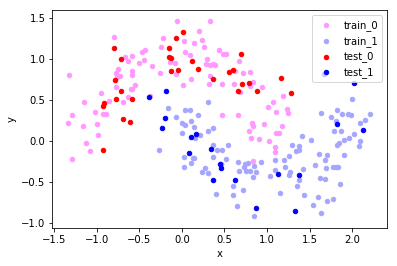

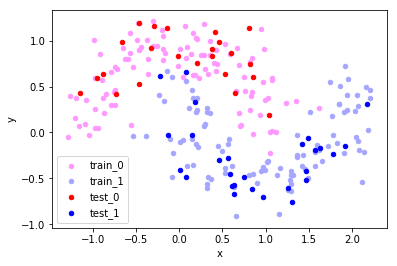

In [5]:
learning_datasets = []
for dataset in dataset_dfs:
    learning_datasets.append(TestDf(dataset))
    
for ldataset in learning_datasets:
    ldataset.show_plot()

Datagram for 0


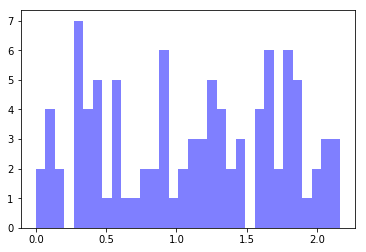

Mean distance for this dataset: 1.102464806360953

Datagram for 1


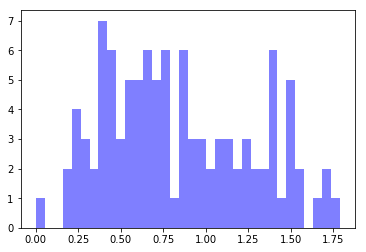

Mean distance for this dataset: 0.8396696568060689

Datagram for 0


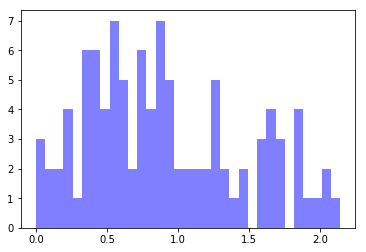

Mean distance for this dataset: 0.9063178164100336

Datagram for 1


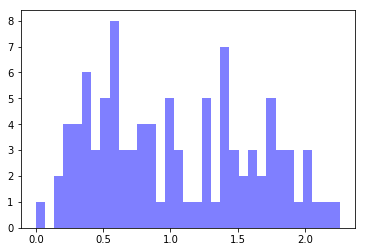

Mean distance for this dataset: 1.038794310076093

Datagram for 0


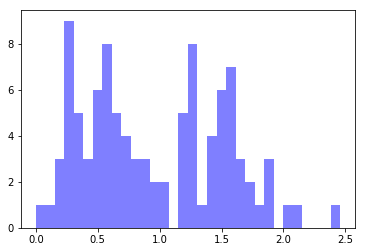

Mean distance for this dataset: 0.9651837446680089

Datagram for 1


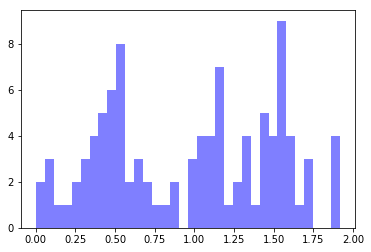

Mean distance for this dataset: 0.9664332847592945

Datagram for 0


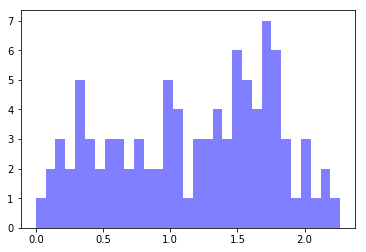

Mean distance for this dataset: 1.1770662681141104

Datagram for 1


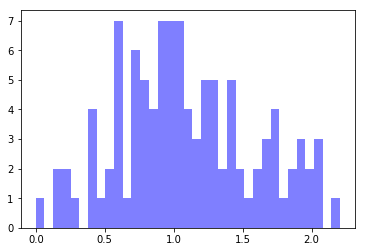

Mean distance for this dataset: 1.0933766064031325

Datagram for 0


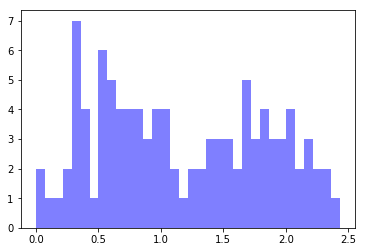

Mean distance for this dataset: 1.1703156983740013

Datagram for 1


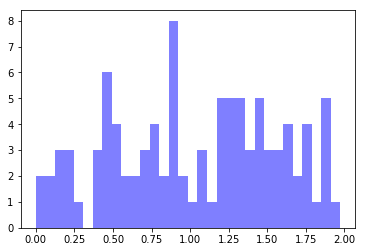

Mean distance for this dataset: 1.0333576523915222



In [6]:
# shows histograms based on distance from first point in dataset
def training_histogram(in_df):
    base_point = in_df.values[0]

    vals = in_df.values
    histogram_data = []
    for item in vals:
        histogram_data.append(distance.euclidean(
            [base_point[1], base_point[2]],
            [item[1], item[2]]))

    #for i in range(10, 60, 10):
    bins = len(histogram_data) / 3
    pyplot.hist(histogram_data, bins, facecolor='blue', alpha=0.5)
    pyplot.show()
    
    mean_distance = np.mean(histogram_data)
    print("Mean distance for this dataset: " + str(mean_distance) + "\n")
    return mean_distance

# finding representation of a cluster with random selection
# pandas.DataFrame in_df
# float delta
def randomSelection(in_df, delta):
    
    medoid_indexes = []
    index_list = list(in_df.index.values)
    
    while (index_list):
        #print("Index length: " + str(len(index_list)))
        # select first unvisited index
        ind = in_df.loc[index_list[0]].name
        #print("Selected index for this run: " + str(ind))
        ref_point = [in_df.loc[ind].values[1], in_df.loc[ind].values[2]]
        rem_indexes = []
        #print("Lenght of in_df: " + str(len(in_df)))
        
        # find indexes to drop from dataframe
        for index, row in in_df.iterrows():
            if distance.euclidean([row['x'], row['y']], ref_point) <= delta:
                rem_indexes.append(index)
        
        index_list = [item for item in index_list if item not in rem_indexes]
        #print("Droping these indexes: " + str(rem_indexes))
        rem_indexes.remove(ind)
        medoid_indexes.append(ind)
        
        in_df = in_df.drop(rem_indexes)
        #print("These indexes remain in in_df: " + str(in_df.index.values))
        
    return in_df
            

    
medoid_lst = []    
for df in learning_datasets: #[0:1]:
    
    print("Datagram for 0")
    mean_0 = training_histogram(df.train_df.loc[df.train_df["label"] == 0])
    medoid_0 = randomSelection(df.train_df.loc[df.train_df["label"] == 0], mean_0/2)
    
    print("Datagram for 1")
    mean_1 = training_histogram(df.train_df.loc[df.train_df["label"] == 1])
    medoid_1 = randomSelection(df.train_df.loc[df.train_df["label"] == 1], mean_1/2)

    medoid_lst.append([df, pd.concat([medoid_0, medoid_1])])

Moving to classify points if they fit to the right dataset by KNeighbors algorithm

In [8]:
def classifyPoints(test):

    X_train = test[0].test_df.iloc[:, 1:].values
    y_train = test[0].test_df.iloc[:, 0].values
    X_test = test[1].iloc[:, 1:].values
    y_test = test[1].iloc[:, 0].values

    from sklearn.preprocessing import StandardScaler  
    scaler = StandardScaler()  
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)

    from sklearn.neighbors import KNeighborsClassifier  
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    from sklearn.metrics import classification_report, confusion_matrix  
    print(confusion_matrix(y_test, y_pred))  
    print(classification_report(y_test, y_pred))
    
for dataset in medoid_lst:
    classifyPoints(dataset)

[[ 6  1]
 [ 3 11]]
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.92      0.79      0.85        14

   micro avg       0.81      0.81      0.81        21
   macro avg       0.79      0.82      0.80        21
weighted avg       0.83      0.81      0.81        21

[[9 2]
 [1 6]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.75      0.86      0.80         7

   micro avg       0.83      0.83      0.83        18
   macro avg       0.82      0.84      0.83        18
weighted avg       0.84      0.83      0.83        18

[[ 9  1]
 [ 1 10]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.91      0.91      0.91        11

   micro avg       0.90      0.90      0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.